In [1]:
from __future__ import absolute_import, division

import os
import urllib
from io import BytesIO     # for handling byte strings
from io import StringIO    # for handling unicode strings

import pymongo as pm
import math
from numpy.linalg import norm

import numpy as np
import scipy.stats as stats
from scipy.spatial import distance
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.metrics import *
import pandas as pd
import json
import re
from joblib import dump, load

from PIL import Image
import base64
import sys

import matplotlib
import matplotlib.patches as mpatches
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['pdf.fonttype'] = 42

import matplotlib.cm as cm
import matplotlib.lines as mlines

plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

from sklearn import linear_model, datasets, neighbors, svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.utils import shuffle
from sklearn.decomposition import PCA


from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler


from IPython.display import clear_output
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")


In [2]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [3]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))
feature_dir = os.path.abspath(os.path.join(proj_dir,'features'))
svg_dir = os.path.abspath(os.path.join(sketch_dir,'svg'))
png_dir = os.path.abspath(os.path.join(sketch_dir,'png'))

## feature dirs
#example_dir = os.path.abspath(os.path.join(feature_dir,'example'))

## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    


## helpers

In [8]:
# a way to read the txt file if we want it:
# f = open(os.path.join(feature_dir,'FEATURES_FC6_sketch.txt'), "r")
# txt = f.readlines()
# print(np.array(txt[1].split(',')).astype(np.float) - np.array(txt[0].split(',')).astype(np.float))


In [4]:
feat_files = ['FEATURES_IMG_64.npy',
              'FEATURES_P1_sketch_channel-norm.npy',
              'FEATURES_P2_sketch_channel-norm.npy',
              'FEATURES_P3_sketch_channel-norm.npy',
              'FEATURES_P4_sketch_channel-norm.npy',
              'FEATURES_P5_sketch_channel-norm.npy',
              'FEATURES_FC6_sketch_channel-norm.npy',
              'FEATURES_FC7_sketch_channel-norm.npy']

def MakeFEAT(layernum):
    FEAT = np.load(os.path.join(feature_dir, feat_files[layernum]))
    feat_num = np.shape(FEAT)[1]
    FEAT = pd.DataFrame(FEAT)
    feat_cols = [str(i) for i in np.arange(feat_num)]
    FEAT.columns = feat_cols
    return FEAT

FEAT0 = MakeFEAT(0)
FEAT1 = MakeFEAT(1)
FEAT2 = MakeFEAT(2)
FEAT3 = MakeFEAT(3)
FEAT4 = MakeFEAT(4)
FEAT5 = MakeFEAT(5)
FEAT6 = MakeFEAT(6) # the one we like best
FEAT7 = MakeFEAT(7)
# FEAT_ = MakeFEAT(8) # stims

all_feats = [FEAT0,FEAT1,FEAT2,FEAT3,FEAT4,FEAT5,FEAT6,FEAT7]
feat_num = np.shape(FEAT6)[1] # our default


META = pd.read_csv(os.path.join(feature_dir,'METADATA_sketch.csv'))
assert META.shape[0]==FEAT6.shape[0]
META['game_id'] = META.sketch_id.str.split('•|\\_').str[0]
META['animal'] = META.sketch_id.str.split('•|\\_').str[1]
META['cardinality'] = META.sketch_id.str.split('•|\\_').str[2]
META['trial_num'] = META.sketch_id.str.split('•|\\_').str[3]
META['condition'] = META.sketch_id.str.split('•|\\_').str[4]
META.drop(columns=['feature_ind'],inplace=True)

D0 = pd.concat([META,FEAT0],axis=1)
D1 = pd.concat([META,FEAT1],axis=1)
D2 = pd.concat([META,FEAT2],axis=1)
D3 = pd.concat([META,FEAT3],axis=1)
D4 = pd.concat([META,FEAT4],axis=1)
D5 = pd.concat([META,FEAT5],axis=1)
D6 = pd.concat([META,FEAT6],axis=1)
D7 = pd.concat([META,FEAT7],axis=1)
# D_ = pd.concat([META,FEAT_],axis=1)

all_dfs = [D0,D1,D2,D3,D4,D5,D6,D7]

D = pd.concat([META,FEAT6],axis=1) # our default

# sort each kind of game
shape_games = D[D['condition'] == 'shape']
number_games = D[D['condition'] == 'number']

print('Done!')

# for layernum in range(len(feat_files)):
#     thing = np.load(os.path.join(feature_dir, feat_files[layernum]))
#     print("Layer {}: ".format(str(layernum)))
#     print(np.max(thing))
    

Done!


In [5]:
def diag_struct(df, sorting, pre_avg = False, post_avg = False):
    feat_cols = [str(i) for i in np.arange(feat_num)]
    df = df.sort_values(sorting)
    if pre_avg == False:
        mat = np.array(df[feat_cols])
        answer = squareform(pdist(mat))
    elif post_avg == False:
        df = df.groupby(sorting).mean()
        mat = np.array(df[feat_cols])
        answer = squareform(pdist(mat))
    elif post_avg == True:    # https://stackoverflow.com/questions/41874452/averaging-over-subsets-of-array-in-numpy
        mat = np.array(df[feat_cols])
        mat = squareform(pdist(mat))
        labels = [val for sublist in df.sort_values(sorting)[[sorting]].values.tolist() for val in sublist]        
        numcats = len(np.unique(labels))        # this assumes that each category occurs equally many times
        res = int(len(labels)/numcats)
        averaged = np.zeros((numcats,numcats))
        for i in range(numcats):
            for j in range(numcats):
                averaged[i,j] = mat[i*res:i*res+res,j*res:j*res+res].mean()
        answer = averaged
    return answer

def plot_lines(ax,mat,cats):
    ticks = []
    for i in range(1,cats+1):
        ax.axhline(int(i*len(mat)/cats)-1,color='white',lw=1)
        ax.axvline(int(i*len(mat)/cats)-1,color='white',lw=1)
        ticks.append(int(i*len(mat)/cats)-1)

def diag_nice_plot(ax,mat,labels,lines=True):
    ticks = []
    if lines == True:
        cats = len(labels)
        for i in range(1,cats+1):
            ax.axhline(int(i*len(mat)/cats)-1,color='white',lw=1)
            ax.axvline(int(i*len(mat)/cats)-1,color='white',lw=1)
            ticks.append(int(i*len(mat)/cats)-1)
    ax.xaxis.set_ticks(ticks)
    ax.yaxis.set_ticks(ticks)
    ax.xaxis.set_major_locator(plt.MaxNLocator(len(labels)))
    ax.yaxis.set_major_locator(plt.MaxNLocator(len(labels)))
    ax.set_xticklabels(labels,fontsize=10)
    ax.set_yticklabels(labels,fontsize=10)

def make_mask(labels):
    """
    Returns an array with True for all the within-category comparisons and False for between-category
    """
    one = np.array([labels]*len(labels))
    two = np.array([labels]*len(labels)).T
    mask = one == two
    return mask

def Ftest(df,feat,condition,category):
    feat_cols = [str(i) for i in np.arange(np.shape(feat)[1])] 
    
    subset = df[df['condition'] == condition]
    
    # making numerator of f test ratio (between group variance)
    total_mean = np.array(subset.groupby('condition').mean()[feat_cols]) # x_mean
    group_means = np.array(subset.groupby([category]).mean()[feat_cols]) # x_i
    btwn_dists = np.sqrt(np.sum( ((group_means - total_mean) ** 2),axis=1)) # Σ(x_i - x_mean)^2
#     dist = distance.euclidean(group_means[0], total_mean), distance.euclidean(group_means[1], total_mean)
    
    K = len(group_means) # = 4 or 8, shape or number
#     mean_dist = np.mean(btwn_dists)
#     var_btwn = np.sum((btwn_dists-mean_dist)**2)/(K-1) # Σ(n_i(dists^2)) / (K-1)  ## n_i is irrelevant because n1=n2=n3=n4
    var_btwn = np.sum(btwn_dists**2)/(K-1)
    
    # making denominator (within group variance)    
    wthn_dists_allgroups = []
    for level in subset.groupby([category])[category]:
        group = np.array(subset[subset[category] == level[0]][feat_cols]) # level[0] is animal or cardinality
        groupmean = np.mean(group,axis=0)
        wthn_dists = np.sqrt(np.sum(((group - groupmean) ** 2),axis=1))
#         wthn_dists = np.sum((wthn_dists - np.mean(wthn_dists))**2)  # new....
        wthn_dists_allgroups.append(wthn_dists)
    N = len(subset) # = 1920
    var_wthn = np.sum(np.array(wthn_dists_allgroups)**2) / (N-K)
    
    return var_btwn / var_wthn #var_btwn / var_wthn

def cf95(arr, z=1.96):
    mean = np.mean(arr)
    std = np.std(arr)
    answer = z * std / np.sqrt(np.size(arr))
    return answer


# Distance Analyses

## Step 1) Make an average distance heatmap for every layer, sorted by game

In [6]:

def H(subplots,i,gametypes,categories,mean_first=False):
    """ 'i' is layer number;
    gametype is what condition ('C' cardinality, 'A' animal);
    categories is how we're sorting it ('C' cardinality, 'A' animal).
    
    We want to take the mean, in general. This breaks if mean==False.
    
    mean_dists means just looking at distances between mean representations within category. It gives nice diagonals.
    
    This function requires that all_dfs and all_feats both exist"""
    
    print("Working on layer {}".format(str(i)))
    clear_output(wait=True)
    
    maxes = []
    mins = []
    arrs = []
    for plot in range(len(subplots)):
        ax = subplots[plot]
        gametype = gametypes[plot]
        category = categories[plot]
        
        df = all_dfs[i]
        if gametype == 'C':
            df = df[df['condition'] == 'number']
        elif gametype == 'A':
            df = df[df['condition'] == 'shape']

        feat = all_feats[i]
        featnum = np.shape(feat)[1]
        featcols = [str(j) for j in np.arange(featnum)]

        if category == 'C':
            sort = df.sort_values(['condition','cardinality','animal','game_id']) # ALL games sorted by Cardinality
            if mean_first == True:
                sort = sort.groupby(['condition','cardinality']).mean()
        elif category == 'A':
            sort = df.sort_values(['condition','animal','cardinality','game_id'])
            if mean_first == True:
                sort = sort.groupby(['condition','animal']).mean()

        
        arr = np.array(sort[featcols])
        arr = squareform(pdist(arr))

        if mean_first == False:
            types = sort['cardinality'].unique() if category == 'C' else sort['animal'].unique()
            numcats = len(types)
            arrnew = np.zeros((numcats,numcats))
            binsize = int(len(arr) / numcats)

            for j in range(numcats):
                for k in range(numcats):
                    arrnew[j,k] = np.mean(arr[j*binsize:j*binsize+binsize,
                                              k*binsize:k*binsize+binsize])
            arr = arrnew
        
        
        minimum,maximum = np.min(arr),np.max(arr)
        arrs.append(arr)
        mins.append(minimum)
        maxes.append(maximum)
        
    
    totalmin = max(mins)
    totalmax = max(maxes)
#     print(totalmin,totalmax)
            
    for plot in range(len(subplots)):
        arr = arrs[plot]
        ax = subplots[plot]
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(arr, cmap='copper', interpolation='nearest')#,vmin=totalmin,vmax=totalmax)
    return 'okay'



[Text(0,0,'Bear'), Text(0,0,'Deer'), Text(0,0,'Owl'), Text(0,0,'Rabbit')]

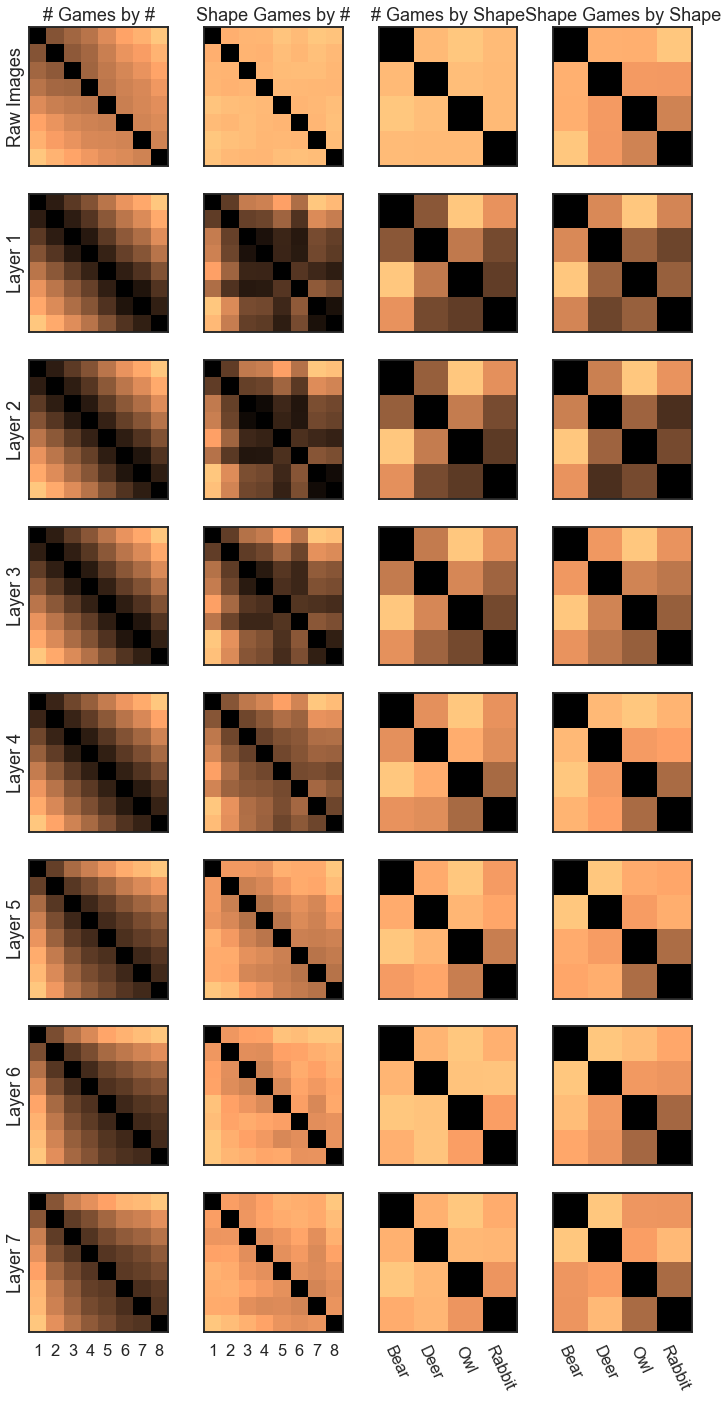

In [12]:

# N = number, S = shape; C = cardinality, A = animal
# just using 'ax' + 'C' cardinality or 'A' animal + layer_number

fig, ((axCC0,axAC0,axCA0,axAA0), (axCC1,axAC1,axCA1,axAA1),
      (axCC2,axAC2,axCA2,axAA2), (axCC3,axAC3,axCA3,axAA3),
      (axCC4,axAC4,axCA4,axAA4), (axCC5,axAC5,axCA5,axAA5),
      (axCC6,axAC6,axCA6,axAA6), (axCC7,axAC7,axCA7,axAA7)) = plt.subplots(len(all_dfs),4, figsize=(12,24))
axes = [axCC0,axAC0,axCA0,axAA0,axCC1,axAC1,axCA1,axAA1,axCC2,axAC2,axCA2,axAA2,axCC3,axAC3,axCA3,axAA3,
        axCC4,axAC4,axCA4,axAA4,axCC5,axAC5,axCA5,axAA5,axCC6,axAC6,axCA6,axAA6,axCC7,axAC7,axCA7,axAA7]

gametypes = ['C','A','C','A']
categories = ['C','C','A','A']

for i in range(int(len(axes)/4)):
    plots = axes[i*4:i*4+4]
    H(plots,i,gametypes,categories,mean_first=True)

axCC0.set_title("# Games by #")
axAC0.set_title('Shape Games by #')
axCA0.set_title('# Games by Shape')
axAA0.set_title('Shape Games by Shape')

axCC0.set_ylabel("Raw Images")
axCC1.set_ylabel("Layer 1")
axCC2.set_ylabel("Layer 2")
axCC3.set_ylabel("Layer 3")
axCC4.set_ylabel("Layer 4")
axCC5.set_ylabel("Layer 5")
axCC6.set_ylabel("Layer 6")
axCC7.set_ylabel("Layer 7")

axCC7.set_xticks([0,1,2,3,4,5,6,7])
axAC7.set_xticks([0,1,2,3,4,5,6,7])
axCA7.set_xticks([0,1,2,3])
axAA7.set_xticks([0,1,2,3])


axCC7.set_xticklabels(["1","2","3","4","5","6","7","8"])
axAC7.set_xticklabels(["1","2","3","4","5","6","7","8"])
axCA7.set_xticklabels(["Bear","Deer","Owl","Rabbit"],rotation=295)
axAA7.set_xticklabels(["Bear","Deer","Owl","Rabbit"],rotation=295)




## Step 2) Plot the F-statistics for each layer

Text(0.5,0,'Layer (0 is raw images)')

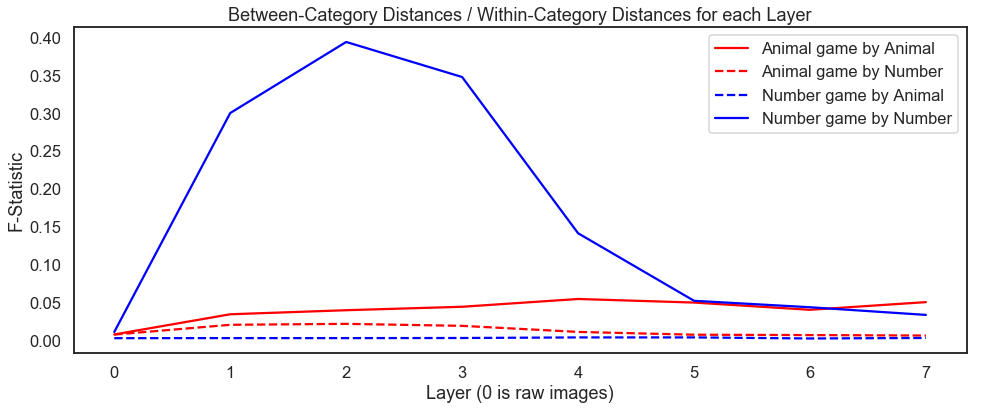

In [13]:
shape_animal = []
for i in range(len(all_dfs)):
    shape_animal.append(Ftest(all_dfs[i],all_feats[i],'shape','animal'))

shape_cardinality = []
for i in range(len(all_dfs)):
    shape_cardinality.append(Ftest(all_dfs[i],all_feats[i],'shape','cardinality'))

number_animal = []
for i in range(len(all_dfs)):
    number_animal.append(Ftest(all_dfs[i],all_feats[i],'number','animal'))

number_cardinality = []
for i in range(len(all_dfs)):
    number_cardinality.append(Ftest(all_dfs[i],all_feats[i],'number','cardinality'))

plt.figure(figsize = (16,6))
plt.title("Between-Category Distances / Within-Category Distances for each Layer")
plt.plot(np.arange(len(all_dfs)),shape_animal,'r',label="Animal game by Animal")
plt.plot(np.arange(len(all_dfs)),shape_cardinality,'r--',label="Animal game by Number")
plt.plot(np.arange(len(all_dfs)),number_animal,'b--',label="Number game by Animal")
plt.plot(np.arange(len(all_dfs)),number_cardinality,'b',label="Number game by Number")
plt.legend()
plt.ylabel("F-Statistic")
plt.xlabel("Layer (0 is raw images)")

# Then do classifier-based things

### within game type, train logistic classifier (5-fold) and measure (1) accuracy & (2) confusion (structure of error; e.g. is 5 often confused with 6? Are deer often confused with bear? Do each for each game type)

In [99]:
def getCLF(i,gametype,category): # i is the layer number. Train on gametype data, to classify category
    df = all_dfs[i]
    feat = all_feats[i]
    featnum = np.shape(feat)[1]
    featcols = [str(j) for j in np.arange(featnum)]
    
    if gametype == 'C':
        df = df[df['condition'] == 'number']
    elif gametype == 'A':
        df = df[df['condition'] == 'shape']
    X = np.array(df[featcols])
    
    if category == 'C':
        y = df['cardinality'].values
    elif category == 'A':
        y = df['animal'].values

    # divide up the testing and training portions of the data
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.1,
                                                        shuffle=True)
    # make and train the classifier
    clf = linear_model.LogisticRegression(penalty='l2',
                                          C=1e-3,
                                          random_state=0,
                                          solver='lbfgs',
                                          multi_class='multinomial',
                                          max_iter=1500)#.fit(X_train, y_train)
    
    metadata = [df['game_id'].values,
                df['condition'].values,
                df['animal'].values,
                df['cardinality'].values,
                df['trial_num'].values,
                df['sketch_id'].values]
    
    # want to save X,y, and metadata for 
    return clf, [X_test,y_test], [X_train,y_train], [X,y], metadata


all_layerCLFs = []
test_sets = []
train_sets = []
Xs = []
ys = []
metadatas = []

for i in range(len(all_dfs)):
    print("Working on layer {}".format(str(i)))
    clear_output(wait=True)
    AA = getCLF(i,'A','A')
    AC = getCLF(i,'A','C')
    CA = getCLF(i,'C','A')
    CC = getCLF(i,'C','C')
    
    layerCLFs = [AA[0],AC[0],CA[0],CC[0]]
    all_layerCLFs.append(layerCLFs)
    
    layer_test_sets = [AA[1],AC[1],CA[1],CC[1]]
    test_sets.append(layer_test_sets)
    
    layer_train_sets = [AA[2],AC[2],CA[2],CC[2]]
    train_sets.append(layer_train_sets)

    Xs.append([AA[3][0],AC[3][0],CA[3][0],CC[3][0]])
    ys.append([AA[3][1],AC[3][1],CA[3][1],CC[3][1]])
    metadatas.append([AA[4],AC[4],CA[4],CC[4]])
    
    
all_layerCLFs = np.array(all_layerCLFs)
test_sets = np.array(test_sets) # index it like test_sets[i,j,k] where i = layer, j = combo, k = X (0) or y (1)
train_sets = np.array(train_sets)
Xs = np.array(Xs)
ys = np.array(ys)
metadatas = np.array(metadatas)
print("Xs shape is {}; metadata shape is {}".format(np.shape(Xs),np.shape(metadatas)))

print("Done")

Xs shape is (8, 4); metadata shape is (8, 4, 6)
Done


In [31]:
# get all the accuracy scores
folds = 5
all_CLFscores = np.zeros((np.shape(all_layerCLFs)[0],np.shape(all_layerCLFs)[1],folds))

for i in range(np.shape(all_CLFscores)[0]):
    for j in range(np.shape(all_CLFscores)[1]):
        print("Working on layer {}, {}th condition".format(i,j+1))
        clear_output(wait=True)
        thing = cross_validate(all_layerCLFs[i,j], test_sets[i,j,0], test_sets[i,j,1], # X=0, y=1
                                            cv=folds, return_train_score=True)
        all_CLFscores[i,j,:] = np.array(thing['test_score'])
        
print("Done")

Done


In [97]:

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
Xblah, yblah = load_iris(return_X_y=True)

print(np.shape(Xblah),np.shape(yblah))
print(Xblah[:2, :])

(150, 4) (150,)
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]]


No handles with labels found to put in legend.


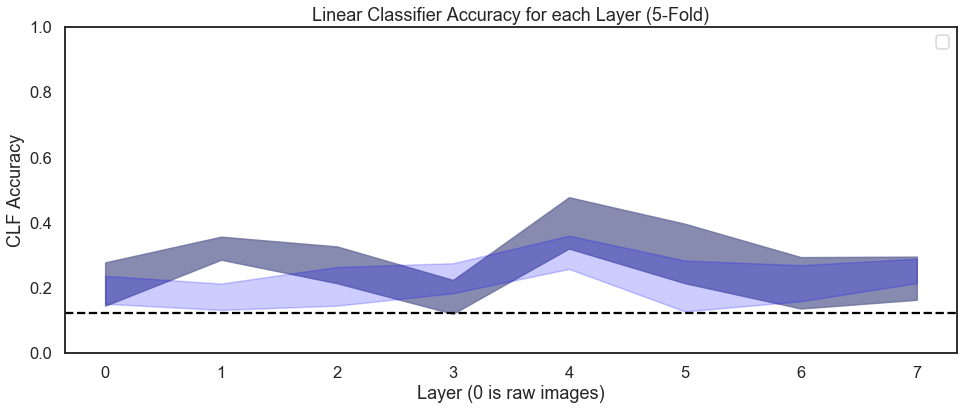

In [258]:


shape_animal = np.mean(all_CLFscores,axis=2)[:,0]

shape_cardinality = np.mean(all_CLFscores,axis=2)[:,1]

number_animal = np.mean(all_CLFscores,axis=2)[:,2]

number_cardinality = np.mean(all_CLFscores,axis=2)[:,3]

plt.figure(figsize = (16,6))
plt.title("Linear Classifier Accuracy for each Layer (5-Fold)")
# plt.plot(np.arange(len(all_dfs)),shape_animal,'r',label="Animal game by Animal")
# plt.plot(np.arange(len(all_dfs)),shape_cardinality,'r--',label="Animal game by Number")
# plt.plot(np.arange(len(all_dfs)),number_animal,'b--',label="Number game by Animal")
# plt.plot(np.arange(len(all_dfs)),number_cardinality,'b',label="Number game by Number")

#plot 95 CIs
lb = np.mean(all_CLFscores,axis=2) - (1.96 * np.std(all_CLFscores,axis=2) / np.sqrt(folds))
ub = np.mean(all_CLFscores,axis=2) + (1.96 * np.std(all_CLFscores,axis=2) / np.sqrt(folds))

# plt.fill_between(np.arange(len(all_dfs)), lb[:,0], ub[:,0], color='#b53819', alpha=0.8)
plt.fill_between(np.arange(len(all_dfs)), lb[:,2], ub[:,2], color='#6a6e9c', alpha=0.8)
# plt.fill_between(np.arange(len(all_dfs)), lb[:,1], ub[:,1], color='r', alpha=0.2)
plt.fill_between(np.arange(len(all_dfs)), lb[:,3], ub[:,3], color='b', alpha=0.2)

# plt.legend()
plt.ylim([0,1])
plt.ylabel("CLF Accuracy")
plt.xlabel("Layer (0 is raw images)")
# plt.axhline(0.25,color='black',ls='--')
plt.axhline(0.125,color='black',ls='--')

### ACCURACY:

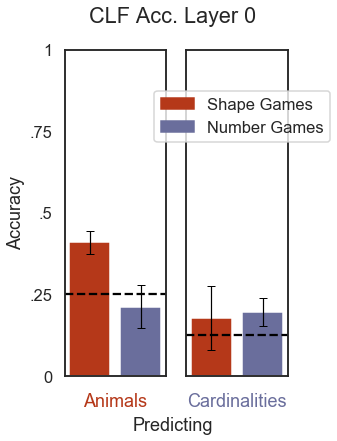

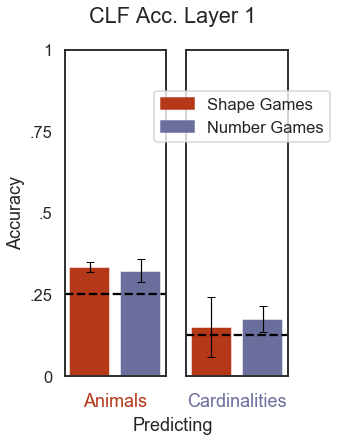

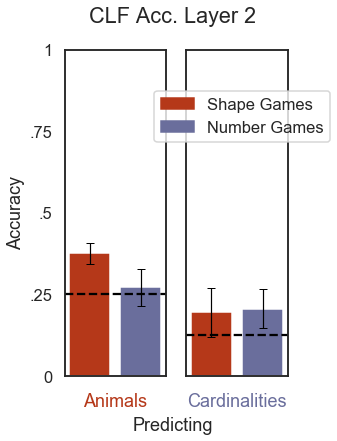

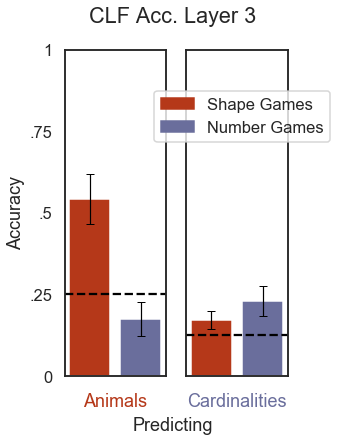

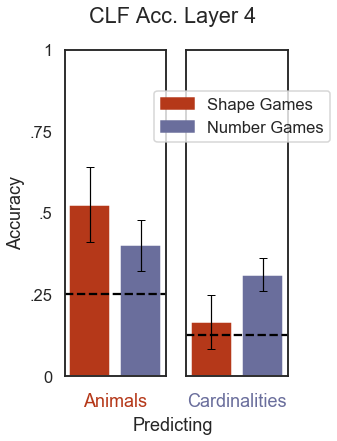

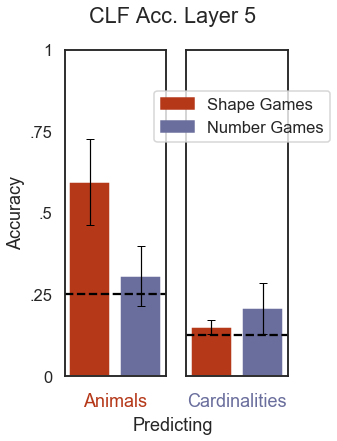

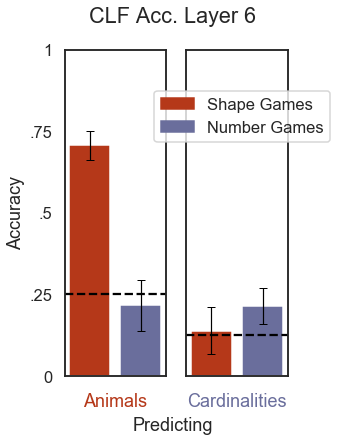

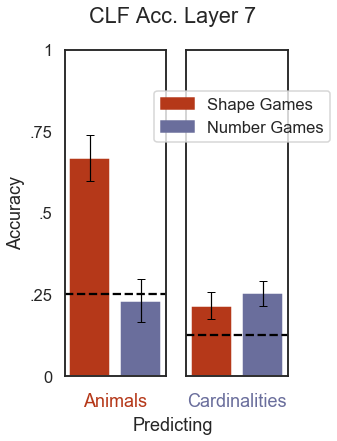

In [251]:

for i in range(len(all_dfs)):
    fig , (ax1,ax2) = plt.subplots(1,2 , sharey=True, figsize = (4,6))

    ax1.set_ylim(0,1)

    fig.suptitle("CLF Acc. Layer {}".format(i))


    ax1.bar(["AA","CA"],
            [np.mean(all_CLFscores[i,0]),
             np.mean(all_CLFscores[i,2])],
           color = ['#b53819','#6a6e9c'],
           yerr = [cf95(all_CLFscores[i,0]),
                   cf95(all_CLFscores[i,2])], error_kw={'linewidth':1.2,'capsize':4})

    ax1.set_xlabel("Animals",color='#b53819')
    ax1.set_xticklabels([])
    ax1.set_yticks([0,.25,.5,.75,1])
    ax1.set_yticklabels(['0','.25','.5','.75','1'])

    ax2.bar(["AC","CC"],
            [np.mean(all_CLFscores[i,1]),
             np.mean(all_CLFscores[i,3])],
           color = ['#b53819','#6a6e9c'],
           yerr = [cf95(all_CLFscores[i,1]),
                   cf95(all_CLFscores[i,3])], error_kw={'linewidth':1.2,'capsize':4})

    ax2.set_xlabel("Cardinalities",color='#6a6e9c')
    ax2.set_xticklabels([])

    l1=ax1.axhline(0.25,color='black',ls='--')
    l1.set_label('l1')

    l2=ax2.axhline(0.125,color='black',ls='--')
    l2.set_label('l2')

    ax1.set_ylabel("Accuracy")
    fig.text(0.5, 0, 'Predicting', ha='center')

    colors = ['#b53819', '#6a6e9c']
    texts = ["Shape Games", "Number Games"]
    patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
    ax2.legend(handles=patches, bbox_to_anchor=(1.5, .9), ncol=1 )

    name = '../results/GIFs/temp{}.png'.format(i)
    fig.savefig(name)

im_list = []
for i in range(len(all_dfs)):
    name = '../results/GIFs/temp{}.png'.format(i)
    im = Image.open(name)
    im_list.append(im)
im_end = im.copy()
im_end = im_end.point(lambda p: p - 200)
im_list.append(im_end)

im_list[0].save('../results/GIFs/CLF_acc.gif', save_all=True, append_images=im_list[1:])

# the following will slow down the output GIF, but they require imagemagick, so install that
# http://blog.floriancargoet.com/slow-down-or-speed-up-a-gif-with-imagemagick/
! identify -verbose ../results/GIFs/CLF_acc.gif | grep Delay
! convert -delay 100x100 ../results/GIFs/CLF_acc.gif ../results/GIFs/CLF_acc.gif

# fig.savefig('../results/CLF_acc_layer6.pdf')

## Do Softmax probabilities

In [102]:
# first get all the softmax outputs from each CLF
#for now, hard-coding in the number of cardinalities and animals

aml_labels = ['bear','deer','owl','rabbit']
num_labels = ['0','1','2','3','4','5','6','7']

def get_guess(names,softmax,labels): # "names" is e.g. 'aml_labels' above; "labels" is the target labels for the CLF
    guesses = []
    for i in range(len(labels)):
        name = labels[i]
        index = names.index(name)
        guess = softmax[i,index]
        guesses = np.append(guesses,guess)
    return np.array(guesses)

all_CLFprobsAA = pd.DataFrame(columns=['layer','game_id','condition','animal','cardinality','trial_num','sketch_id','prob','clf'])        
all_CLFprobsAC = pd.DataFrame(columns=['layer','game_id','condition','animal','cardinality','trial_num','sketch_id','prob','clf'])
all_CLFprobsCA = pd.DataFrame(columns=['layer','game_id','condition','animal','cardinality','trial_num','sketch_id','prob','clf'])
all_CLFprobsCC = pd.DataFrame(columns=['layer','game_id','condition','animal','cardinality','trial_num','sketch_id','prob','clf'])

prob_dfs = [all_CLFprobsAA,all_CLFprobsAC,all_CLFprobsCA,all_CLFprobsCC]

for i in range(np.shape(all_layerCLFs)[0]):
    for j in range(np.shape(all_layerCLFs)[1]):
        print("Working on layer {}, {}th condition".format(i,j+1))
        clear_output(wait=True)

        if j in [0,2]: # that is, if CLF is trained to predict shape
#             aml_probs = all_layerCLFs[i,j].predict_proba(Xs[i,j]) # used to be testing on test_sets[i,j,0]
            aml_probs = cross_val_predict(all_layerCLFs[i,j], Xs[i,j], ys[i,j], cv=5, method='predict_log_proba')
            
            aml_targ_probs = get_guess(aml_labels, aml_probs, metadatas[i,j,2])
            cur_data = metadatas[i,j,:]
            layer_col = np.array([str(i)]*len(aml_targ_probs)) # what layer of the net are we in
            clf_col = np.array(["shape"]*len(aml_targ_probs)) # what is the clf trying to predict?
            cur_df = pd.DataFrame(np.array([layer_col,cur_data[0],cur_data[1],cur_data[2],cur_data[3],cur_data[4],
                                            cur_data[5],aml_targ_probs,clf_col]).T,
                                 columns=['layer','game_id','condition','animal','cardinality','trial_num','sketch_id','prob','clf'])
            prob_dfs[j] = prob_dfs[j].append(cur_df)
            
        else: # that is, if CLF is trained to predict number
#             num_probs = all_layerCLFs[i,j].predict_proba(Xs[i,j]) # used to be testing on test_sets[i,j,0]
            # https://stackoverflow.com/questions/28787500/predict-proba-for-a-cross-validated-model
            num_probs = cross_val_predict(all_layerCLFs[i,j], Xs[i,j], ys[i,j], cv=5, method='predict_log_proba')
    
            num_targ_probs = get_guess(num_labels, num_probs, metadatas[i,j,3])
            cur_data = metadatas[i,j,:]
            layer_col = np.array([str(i)]*len(num_targ_probs)) # what layer of the net are we in
            clf_col = np.array(["number"]*len(num_targ_probs)) # what is the clf trying to predict?
            cur_df = pd.DataFrame(np.array([layer_col,cur_data[0],cur_data[1],cur_data[2],cur_data[3],cur_data[4],
                                            cur_data[5],num_targ_probs,clf_col]).T,
                                 columns=['layer','game_id','condition','animal','cardinality','trial_num','sketch_id','prob','clf'])
            prob_dfs[j] = prob_dfs[j].append(cur_df)
            

        
print("Done")


CLF_targ_probs = pd.DataFrame(columns=['layer','game_id','condition','animal','cardinality','trial_num','sketch_id','prob','clf'])     
for prob_df in prob_dfs:
    CLF_targ_probs = CLF_targ_probs.append(prob_df)

CLF_targ_probs.to_csv('../results/csv/CLF_targ_probs.csv')




Done


In [103]:

CLF_targ_probs


,layer,game_id,condition,animal,cardinality,trial_num,sketch_id,prob,clf
0,0,0196-4a8ca8ea-c82c-4f36-af78-e3374d339786,shape,bear,0,7,0196-4a8ca8ea-c82c-4f36-af78-e3374d339786•bear...,-0.162919,shape
1,0,0196-4a8ca8ea-c82c-4f36-af78-e3374d339786,shape,bear,1,2,0196-4a8ca8ea-c82c-4f36-af78-e3374d339786•bear...,-0.0675232,shape
2,0,0196-4a8ca8ea-c82c-4f36-af78-e3374d339786,shape,bear,2,26,0196-4a8ca8ea-c82c-4f36-af78-e3374d339786•bear...,-4.76012,shape
3,0,0196-4a8ca8ea-c82c-4f36-af78-e3374d339786,shape,bear,3,14,0196-4a8ca8ea-c82c-4f36-af78-e3374d339786•bear...,-1.26638,shape
4,0,0196-4a8ca8ea-c82c-4f36-af78-e3374d339786,shape,bear,4,9,0196-4a8ca8ea-c82c-4f36-af78-e3374d339786•bear...,-0.0143717,shape
...,...,...,...,...,...,...,...,...,...
987,7,9628-d7914c9d-2ee9-4706-8d26-93a3fa8008e3,number,rabbit,3,5,9628-d7914c9d-2ee9-4706-8d26-93a3fa8008e3•rabb...,-1.9531,number
988,7,9628-d7914c9d-2ee9-4706-8d26-93a3fa8008e3,number,rabbit,4,16,9628-d7914c9d-2ee9-4706-8d26-93a3fa8008e3•rabb...,-2.1402,number
989,7,9628-d7914c9d-2ee9-4706-8d26-93a3fa8008e3,number,rabbit,5,30,9628-d7914c9d-2ee9-4706-8d26-93a3fa8008e3•rabb...,-1.37899,number
990,7,9628-d7914c9d-2ee9-4706-8d26-93a3fa8008e3,number,rabbit,6,21,9628-d7914c9d-2ee9-4706-8d26-93a3fa8008e3•rabb...,-2.30534,number


In [9]:
soft_A_all = clf_A.predict_proba(X_A_test)
soft_CA_all = clf_CA.predict_proba(X_CA_test)

soft_C_all = clf_C.predict_proba(X_C_test)
soft_AC_all = clf_AC.predict_proba(X_AC_test)

aml_labels = ['bear','deer','owl','rabbit']
num_labels = ['0','1','2','3','4','5','6','7']

def get_guess(names,softmax,labels):
    guesses = []
    for i in range(len(labels)):
        name = labels[i]
        index = names.index(name)
        guess = softmax[i,index]
        guesses = np.append(guesses,guess)
    return np.array(guesses)

soft_A = get_guess(aml_labels,soft_A_all,y_A_test)
soft_CA = get_guess(aml_labels,soft_CA_all,y_CA_test)

soft_C = get_guess(num_labels,soft_C_all,y_C_test)
soft_AC = get_guess(num_labels,soft_AC_all,y_AC_test)

# copied directly from accuracy bar graph above
fig , (ax1,ax2) = plt.subplots(1,2 , sharey=True, figsize = (4,6))
ax1.set_ylim(0,1)
fig.suptitle("Softmax Correct Probability")
ax1.bar(["A","CA"],
        [np.mean(soft_A),
         np.mean(soft_CA)],
       color = ['#b53819','#6a6e9c'],
       yerr = [cf95(soft_A),
               cf95(soft_CA)], error_kw={'linewidth':1.2,'capsize':4})
ax1.set_xlabel("Animals",color='#b53819')
ax1.set_xticklabels([])
ax1.set_yticks([0,.25,.5,.75,1])
ax1.set_yticklabels(['0','.25','.5','.75','1'])
ax2.bar(["AC","C"],
        [np.mean(soft_AC),
         np.mean(soft_C)],
       color = ['#b53819','#6a6e9c'],
       yerr = [cf95(soft_AC),
               cf95(soft_C)], error_kw={'linewidth':1.2,'capsize':4})
ax2.set_xlabel("Cardinalities",color='#6a6e9c')
ax2.set_xticklabels([])
l1=ax1.axhline(0.25,color='black',ls='--')
l1.set_label('l1')
l2=ax2.axhline(0.125,color='black',ls='--')
l2.set_label('l2')
ax1.set_ylabel("Accuracy")
fig.text(0.5, 0, 'Predicting', ha='center')
colors = ['#b53819', '#6a6e9c']
texts = ["Shape Games", "Number Games"]
patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
ax2.legend(handles=patches, bbox_to_anchor=(1.5, .9), ncol=1 )
fig.savefig('../results/softmax_prob_layer6.pdf')

NameError: name 'clf_A' is not defined

### Confusion Matrices:

NameError: name 'all_layerCLFs' is not defined

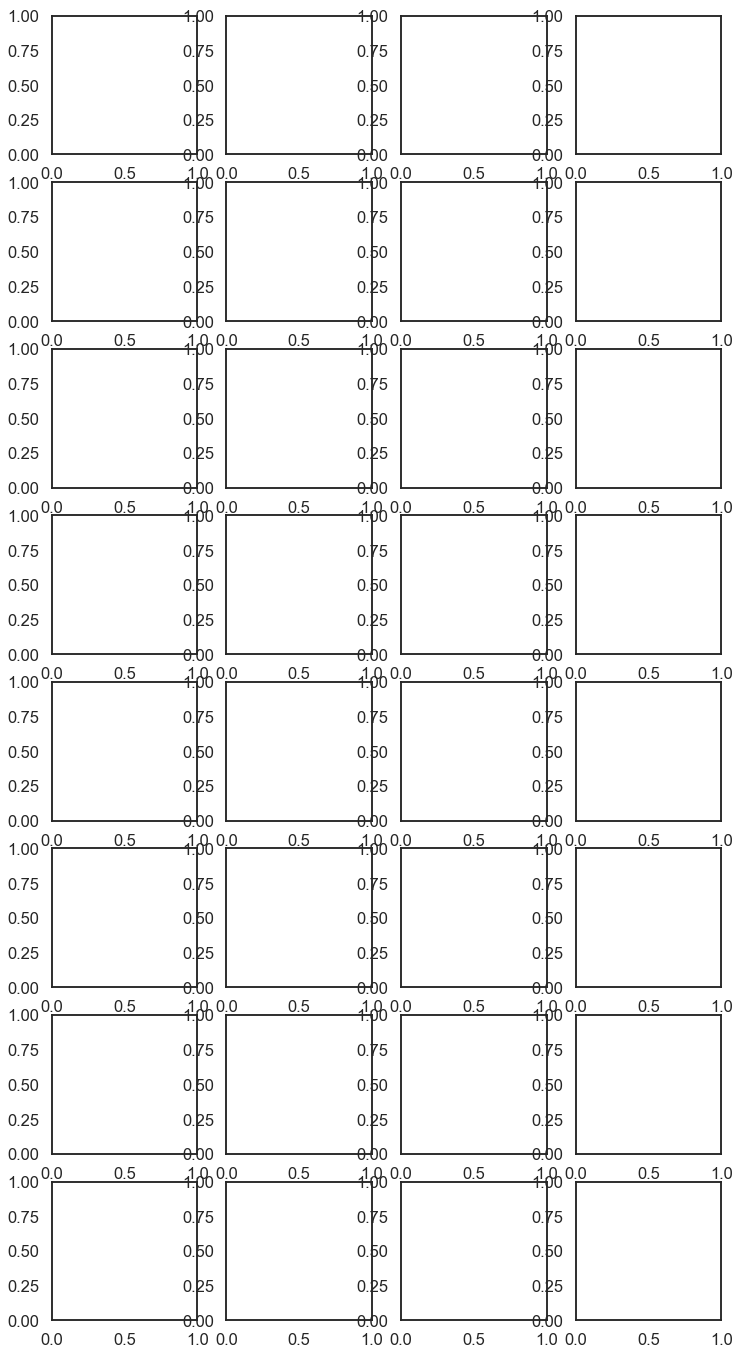

In [8]:

fig, ((axCC0,axAC0,axCA0,axAA0), (axCC1,axAC1,axCA1,axAA1),
      (axCC2,axAC2,axCA2,axAA2), (axCC3,axAC3,axCA3,axAA3),
      (axCC4,axAC4,axCA4,axAA4), (axCC5,axAC5,axCA5,axAA5),
      (axCC6,axAC6,axCA6,axAA6), (axCC7,axAC7,axCA7,axAA7)) = plt.subplots(len(all_dfs),4, figsize=(12,24))
axes = np.array([[axCC0,axAC0,axCA0,axAA0],[axCC1,axAC1,axCA1,axAA1],[axCC2,axAC2,axCA2,axAA2],[axCC3,axAC3,axCA3,axAA3],
        [axCC4,axAC4,axCA4,axAA4],[axCC5,axAC5,axCA5,axAA5],[axCC6,axAC6,axCA6,axAA6],[axCC7,axAC7,axCA7,axAA7]])

# gametypes = ['C','A','C','A']
# categories = ['C','C','A','A']

for i in range(np.shape(axes)[0]): # for every layer
    for j in range(np.shape(axes)[1]): # for each combo
        clf = make_pipeline(MinMaxScaler(), all_layerCLFs[i,j])
        y_pred = cross_val_predict(clf, train_sets[i,j,0], train_sets[i,j,1], cv=5)
        print("Shape is {}".format(np.shape(y_pred)))
        clear_output(wait=True)
        
        conf_mat = confusion_matrix(train_sets[i,j,1], y_pred)
        
        axes[i,j].imshow(conf_mat, cmap='copper', interpolation='nearest')
        
#     plots = axes[i*4:i*4+4]
#     H(plots,i,gametypes,categories,mean_first=True)

# all_layerCLFs

# clf = make_pipeline(MinMaxScaler(), LogisticRegression(penalty='l2',
#                                       C=1e-3,
#                                       random_state=0,
#                                       solver='lbfgs',
#                                       multi_class='multinomial',
#                                       max_iter=1500))

# y_A_pred = cross_val_predict(clf, X_A_train, y_A_train, cv=5)
# y_C_pred = cross_val_predict(clf, X_C_train, y_C_train, cv=5)

# conf_mat_A = confusion_matrix(y_A_train, y_A_pred)
# conf_mat_C = confusion_matrix(y_C_train, y_C_pred)

# Buffer before everything below…

## Trying some PCA

Text(0,0.5,'PC2')

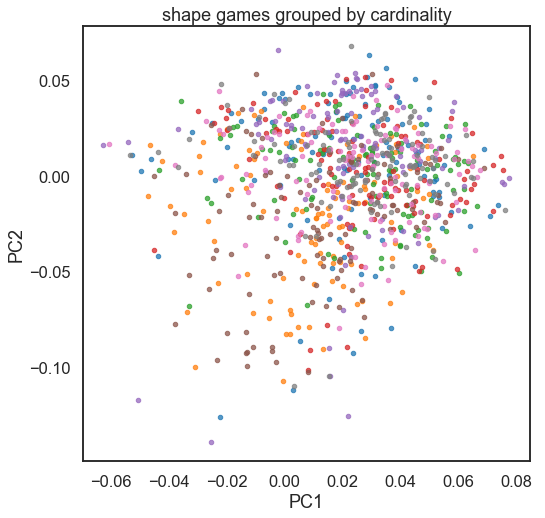

In [83]:
cond = shape_games
comp = 'cardinality'
names = ['bear','deer','owl','rabbit'] if comp == 'animal' else ['0','1','2','3','4','5','6','7']
newD = cond.sort_values(['condition',comp])

x = np.array(newD[feat_cols])
# print(np.shape(x))
# y = np.array([np.mean(x,axis=1)]).T
# print(np.shape(y))
# xy = np.append(x, y, axis=1)
# np.shape(x)
# xy = xy[:,xy[-1].argsort()]
# plt.figure()
# plt.imshow(xy, cmap='copper', interpolation='nearest')

# plt.figure()
# plt.imshow(x, cmap='copper', interpolation='nearest')
# plt.figure(figsize=(8,8))
# plt.imshow(y, cmap='copper', interpolation='nearest',aspect=.0005)


pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x.T)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3'])
# print(pca.explained_variance_ratio_)
# print(np.shape(pca.components_))

# plt.figure(figsize=(8,8))
# plt.imshow(pca.components_, cmap='copper', interpolation='nearest',aspect=500)

labels = [val for sublist in cond[[comp]].values.tolist() for val in sublist]

plt.figure(figsize=(8,8))
plt.title("{} games grouped by {}".format(cond.iloc[0]['condition'],comp))
for label in names:
    ind = np.where(np.array(labels) == label)
    plt.plot(pca.components_[0][ind],pca.components_[1][ind],'.',alpha=.75)
plt.xlabel('PC1')
plt.ylabel('PC2')




## Make Diagonal Structure Plots

In [171]:

# # get lists of labels to make our masking matrix with for within- vs between- category variance comparisons
labelsA  = np.array([val for sublist in shape_games.sort_values('cardinality')[['cardinality']].values.tolist() for val in sublist])
labelsB  = np.array([val for sublist in number_games.sort_values('cardinality')[['cardinality']].values.tolist() for val in sublist])
labelsC  = np.array([val for sublist in shape_games.sort_values('animal')[['animal']].values.tolist() for val in sublist])
labelsD  = np.array([val for sublist in number_games.sort_values('animal')[['animal']].values.tolist() for val in sublist])

# # getting our distance matrices
matA = diag_struct(shape_games,'cardinality')
matB = diag_struct(number_games,'cardinality')
matC = diag_struct(shape_games,'animal')
matD = diag_struct(number_games,'animal')

# and ones where we average in each group AFTER taking distances
# mat1 = diag_struct(shape_games,'cardinality',pre_avg = False, post_avg = True)
# mat2 = diag_struct(number_games,'cardinality',pre_avg = False, post_avg = True)
# mat3 = diag_struct(shape_games,'animal',pre_avg = False, post_avg = True)
# mat4 = diag_struct(number_games,'animal',pre_avg = False, post_avg = True)

# # and ones where we average in each group BEFORE taking distances
mat1 = diag_struct(shape_games,'cardinality',pre_avg = True)
mat2 = diag_struct(number_games,'cardinality',pre_avg = True)
mat3 = diag_struct(shape_games,'animal',pre_avg = True)
mat4 = diag_struct(number_games,'animal',pre_avg = True)


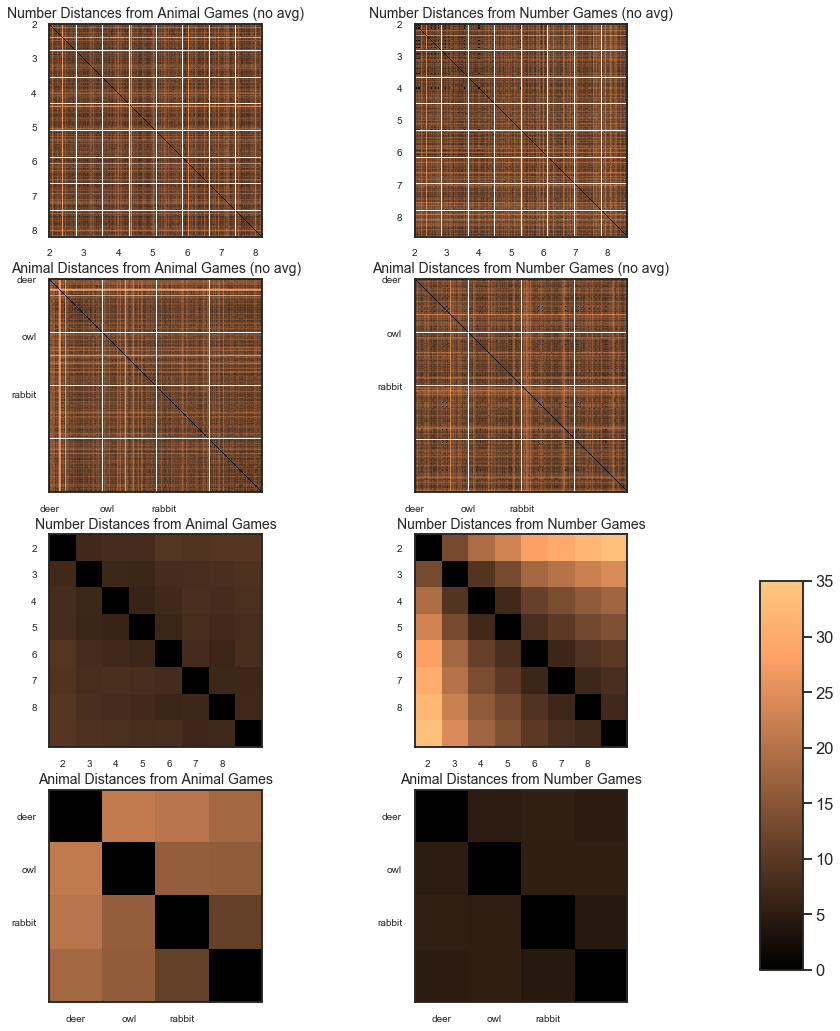

In [172]:
fig, ((axA,axB), (axC,axD), (ax1,ax2), (ax3,ax4)) = plt.subplots(4,2, figsize = (12,18))

axA.set_title("Number Distances from Animal Games (no avg)",fontsize=14)
plotA = axA.imshow(matA, cmap='copper', interpolation='nearest')#, vmin=0,vmax=35)
diag_nice_plot(axA,matA,['1','2','3','4','5','6','7','8'])

axB.set_title("Number Distances from Number Games (no avg)",fontsize=14)
plotB = axB.imshow(matB, cmap='copper', interpolation='nearest')#, vmin=0,vmax=35)
diag_nice_plot(axB,matB,['1','2','3','4','5','6','7','8'])


axC.set_title("Animal Distances from Animal Games (no avg)",fontsize=14)
plotC = axC.imshow(matC, cmap='copper', interpolation='nearest')#, vmin=0,vmax=35)
diag_nice_plot(axC,matC,['bear','deer','owl','rabbit'])

axD.set_title("Animal Distances from Number Games (no avg)",fontsize=14)
plotD = axD.imshow(matD, cmap='copper', interpolation='nearest')#, vmin=0,vmax=35)
diag_nice_plot(axD,matD,['bear','deer','owl','rabbit'])




ax1.set_title("Number Distances from Animal Games",fontsize=14)
plot1 = ax1.imshow(mat1, cmap='copper', interpolation='nearest', vmin=0,vmax=35)
diag_nice_plot(ax1,mat1,['1','2','3','4','5','6','7','8'],lines=False)

ax2.set_title("Number Distances from Number Games",fontsize=14)
plot2 = ax2.imshow(mat2, cmap='copper', interpolation='nearest', vmin=0,vmax=35)
diag_nice_plot(ax2,mat2,['1','2','3','4','5','6','7','8'],lines=False)


ax3.set_title("Animal Distances from Animal Games",fontsize=14)
plot3 = ax3.imshow(mat3, cmap='copper', interpolation='nearest', vmin=0,vmax=35)
diag_nice_plot(ax3,mat3,['bear','deer','owl','rabbit'],lines=False)

ax4.set_title("Animal Distances from Number Games",fontsize=14)
plot4 = ax4.imshow(mat4, cmap='copper', interpolation='nearest', vmin=0,vmax=35)
diag_nice_plot(ax4,mat4,['bear','deer','owl','rabbit'],lines=False)

cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.3])
fig.colorbar(plot1, cax=cbar_ax)





In [ ]:
ax1.xaxis.tick_top()

ax1.set_xticklabels(ax.get_xticks()) #https://stackoverflow.com/questions/41122923/getting-empty-tick-labels-before-showing-a-plot-in-matplotlib
for tick in ax1.get_xticklabels()[:]:
    if float(tick.get_text()) > 1:
        tick.set_color("red")

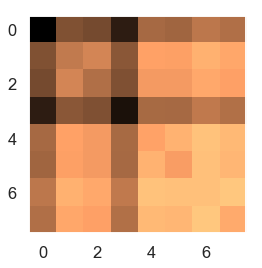

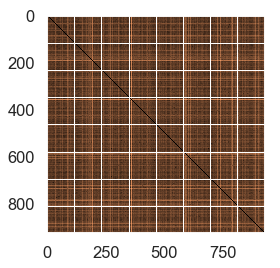

In [298]:
test = diag_struct(shape_games,'cardinality')
# test2 = test.reshape(232,232,4,4)[:,:,0,0]#.mean(axis=-2).shape

num = 8
pix = int(len(test)/num)

test3 = np.zeros((num,num))
for i in range(num):
    for j in range(num):
        test3[i,j] = test[i*pix:i*pix+pix,j*pix:j*pix+pix].mean()


plt.figure()
plt.imshow(test3, cmap='copper', interpolation='nearest',)
plt.show()

plt.figure()
plot_lines(plt,test,8)
plt.imshow(test, cmap='copper', interpolation='nearest')
plt.show()


In [ ]:
# # some simple plots
# plt.title("Animal Distances from Animal Games")
# plot_diag_struct(shape_games,'animal',grouping = 'animal')
# plt.colorbar()
# plt.figure()
# plt.title("Animal Distances from Number Games")
# plot_diag_struct(number_games,'animal',grouping = 'animal')
# plt.colorbar()
# plt.figure()
# plt.title("Cardinality Distances from Animal Games")
# plot_diag_struct(shape_games,'cardinality',grouping = 'cardinality')
# plt.colorbar()
# plt.figure()
# plt.title("Cardinality Distances from Number Games")
# plot_diag_struct(number_games,'cardinality',grouping = 'cardinality')
# plt.colorbar()

# Do some distance measurements
### plot by-game to see between-game (regardless of card/anim) distances

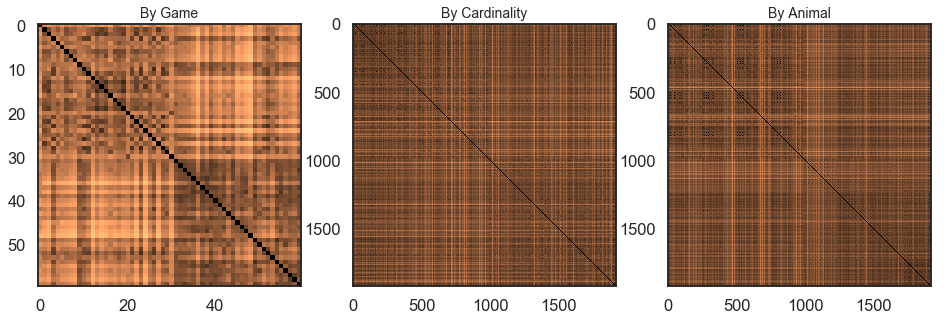

In [12]:

feat_cols = [str(i) for i in np.arange(feat_num)]


# by_game_df1 = D.sort_values(['condition','game_id']).groupby(['condition','game_id']).mean()
# by_game_df2 = D.sort_values(['condition','game_id']).groupby(['condition','cardinality']).mean()
# by_game_df3 = D.sort_values(['condition','game_id']).groupby(['condition','animal']).mean()

by_game_df1 = D.sort_values(['condition','game_id']).groupby(['condition','game_id']).mean()
by_game_df2 = D.sort_values(['condition','game_id']).groupby(['condition','cardinality','animal','game_id']).mean()
by_game_df3 = D.sort_values(['condition','game_id']).groupby(['condition','animal','cardinality','game_id']).mean()


by_game1 = np.array(by_game_df1[feat_cols])
by_game2 = np.array(by_game_df2[feat_cols])
by_game3 = np.array(by_game_df3[feat_cols])

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (16,6))
plt.title("Inter-Game Avg. Sketch Distances",fontsize=14)
ax1.set_title("By Game",fontsize=14)
ax2.set_title("By Cardinality",fontsize=14)
ax3.set_title("By Animal",fontsize=14)

ax1.imshow(squareform(pdist(by_game1)), cmap='copper', interpolation='nearest')
ax2.imshow(squareform(pdist(by_game2)), cmap='copper', interpolation='nearest')
ax3.imshow(squareform(pdist(by_game3)), cmap='copper', interpolation='nearest')

# plt.xticks([15,45], ['Number', 'Shape'],fontsize=14)
# plt.yticks([15,45], ['Number', 'Shape'],fontsize=14,rotation=90)
plt.show()


(1920, 1920)


([<matplotlib.axis.YTick at 0x137717c88>,
 <a list of 16 Text yticklabel objects>)

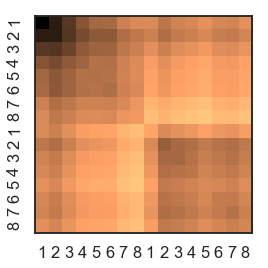

In [29]:
### !!!! Or rather, this:

x = squareform(pdist(by_game2))
plt.imshow(x, cmap='copper', interpolation='nearest')

xnew = np.zeros((16,16))
for i in range(16):
    for j in range(16):
         xnew[i,j] = np.mean(x[i*120:i*120+120,j*120:j*120+120])
#         x[i*240:i*240+240,j*240:j*240+240] = np.mean(x[i*240:i*240+240,j*240:j*240+240])

plt.imshow(xnew, cmap='copper', interpolation='nearest')
plt.xticks(np.arange(16), ['1','2','3','4','5','6','7','8','1','2','3','4','5','6','7','8'], rotation=0)
plt.yticks(np.arange(16), ['1','2','3','4','5','6','7','8','1','2','3','4','5','6','7','8'], rotation=90)


## Used to be the f-test cell:

In [276]:
# shape_games.sort_values('cardinality')
# number_games.sort_values('cardinality')
# shape_games.sort_values('animal')
# number_games.sort_values('animal')

def f_test(df,category):
    feat_cols = [str(i) for i in np.arange(feat_num)]
    
    # making numerator of f test ratio (between group variance)
    total_mean = np.array(df.groupby('condition').mean()[feat_cols])
    group_means = np.array(df.groupby(category).mean()[feat_cols])
    dists = np.sqrt(np.sum(((group_means - total_mean) ** 2),axis=1))
    sum_sq_btwn = np.sum( dists**2  / (len(group_means) - 1), axis = 0)
    
    # making denominator (within group variance)
    group_variances = np.sqrt(np.sum(np.array(df.groupby(category).var()[feat_cols])**2, axis = 1))

    wthn_variance = np.sum(group_variances, axis = 0) / (len(df) - len(group_variances))
    
    return sum_sq_btwn / wthn_variance

# np.shape(np.array(shape_games.groupby('cardinality').mean()[feat_cols]) - np.array(shape_games.groupby('condition').mean()[feat_cols]))


len(np.sum(np.array(shape_games.groupby('cardinality').var()[feat_cols]),axis=1))

print(f_test(shape_games,'cardinality'))
print(f_test(number_games,'cardinality'))
print(f_test(shape_games,'animal'))
print(f_test(number_games,'animal'))



38.31888276329079
203.29647743093489
607.7913208528324
53.048021311631544


### get F-statistic for cardinality or animal as grouping principle (ratio of between- vs within- category variance)

Animal games sorted by animal 0.9040913936397225
Animal games sorted by number 0.8971629858246589 

Number games sorted by number 0.8566372843155982
Number games sorted by animal 0.9540825282043505 



Text(0.5,1,'Number games by animal')

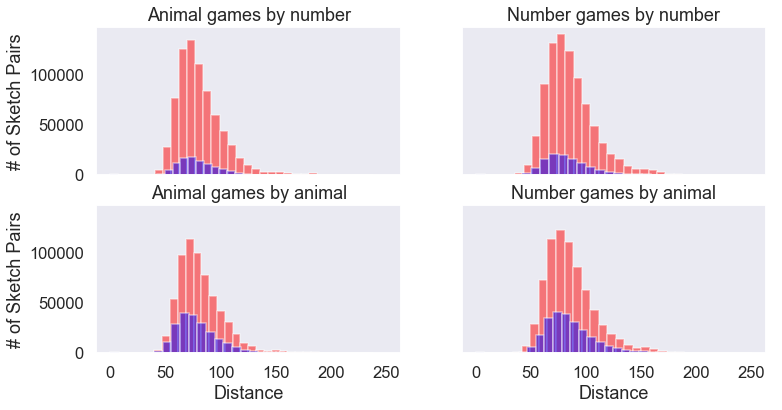

In [126]:

# Don't just plot the ratio of variances - plot all distances and see if within- and between- have overlapping normal curves
def wthn_btwn_var(matrix,labels):
    betwen_cat = np.where(make_mask(labels) == False,matrix,np.nan)
    within_cat = np.where(make_mask(labels) == True,matrix,np.nan)
    return np.nanvar(betwen_cat) / np.nanvar(within_cat)  # use var instead??? But these are already distances...

print("Animal games sorted by animal", wthn_btwn_var(matC,labelsC))
print("Animal games sorted by number", wthn_btwn_var(matA,labelsA),'\n')

print("Number games sorted by number", wthn_btwn_var(matB,labelsB))
print("Number games sorted by animal", wthn_btwn_var(matD,labelsD),'\n')

def wthn_btwn_dist(matrix,labels,subplot):
    betwen_cat = np.where(make_mask(labels) == False, matrix, np.nan)
    within_cat = np.where(make_mask(labels) == True, matrix, np.nan)
    
    betwen_cat = betwen_cat.flatten()
    ii = np.isfinite(betwen_cat)
    betwen_cat = np.sort(betwen_cat[ii])
    
    within_cat = within_cat.flatten()
    ii = np.isfinite(within_cat)
    within_cat = np.sort(within_cat[ii])
    
    
    subplot.hist(betwen_cat,bins=30,color='red',alpha=.5)
    subplot.hist(within_cat,bins=30,color='blue',alpha=.5)
    
    
#     return betwen_cat, within_cat

fig , ((hist1,hist2),(hist3,hist4)) = plt.subplots(2,2,sharex=True,sharey=True,figsize=(12,6))
wthn_btwn_dist(matA,labelsA,hist1)
wthn_btwn_dist(matB,labelsB,hist2)
wthn_btwn_dist(matC,labelsC,hist3)
wthn_btwn_dist(matD,labelsD,hist4)

hist1.set_ylabel('# of Sketch Pairs')
hist3.set_ylabel('# of Sketch Pairs')

hist3.set_xlabel('Distance')
hist4.set_xlabel('Distance')

hist1.set_title("Animal games by number")
hist2.set_title("Number games by number")
hist3.set_title("Animal games by animal")
hist4.set_title("Number games by animal")

# plt.figure()
# plt.plot(range(len(btwn)),btwn,color='red')
# plt.plot(range(len(wthn)),wthn,color='blue')
# plt.show()






In [92]:

# https://stackoverflow.com/questions/49587820/getting-the-confusion-matrix-for-each-cross-validation-fold/49599116
clf = make_pipeline(MinMaxScaler(), LogisticRegression(penalty='l2',
                                      C=1e-3,
                                      random_state=0,
                                      solver='lbfgs',
                                      multi_class='multinomial',
                                      max_iter=1500))

y_A_pred = cross_val_predict(clf, X_A_train, y_A_train, cv=5)
y_C_pred = cross_val_predict(clf, X_C_train, y_C_train, cv=5)

conf_mat_A = confusion_matrix(y_A_train, y_A_pred)
conf_mat_C = confusion_matrix(y_C_train, y_C_pred)


### CONFUSION:

array([110, 114, 111, 109, 117, 113, 108, 110])

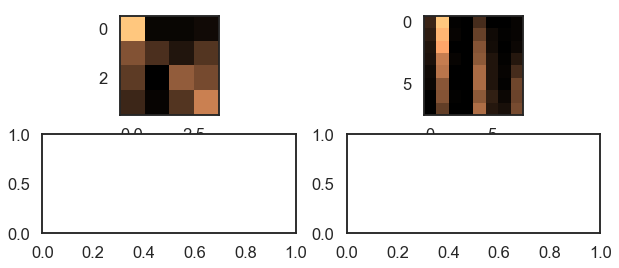

In [93]:
fig , ((ax1,ax2) , (ax3,ax4)) = plt.subplots(2,2 , figsize=(10,4))
ax1.imshow(conf_mat_A, cmap='copper', interpolation='nearest')
ax2.imshow(conf_mat_C, cmap='copper', interpolation='nearest')

# ax3.imshow(conf_mat_AC, cmap='copper', interpolation='nearest')
# ax4.imshow(conf_mat_CA, cmap='copper', interpolation='nearest')

np.sum(conf_mat_C,axis=1)


### track the (3) 'probability' from softmax output to have something continuous

In [218]:
# Xarray-like of shape (n_samples, n_features)
# Vector to be scored, where n_samples is the number of samples and n_features is the number of features.

# DON'T WORRY ABOUT LOG ODDS. JUST TAKE THE WINNING PROBABILITY. Or not: take the probability of the correct label

# softmax:
print(np.argmax(clf_A.predict_proba(X_A_test),axis=1),'\n')
# print(np.sum(clf_C.predict_proba(X_A_train),axis=0),'\n')
# print(np.sum(clf_A.predict_proba(X_C_train),axis=0),'\n')
# print(np.sum(clf_C.predict_proba(X_C_train),axis=0))

test = clf_A.predict_proba(X_A_test)
test[:] = 0
for i in range(len(test)):
    test[i,np.argmax(clf_A.predict_proba(X_A_test),axis=1)[i]] = 1
    
print(len(test), len(clf_A.predict_proba(X_A_test)))

# print(clf_C.classes_)


[3 1 2 3 3 1 3 1 1 2 2 2 3 2 3 2 0 3 2 2 3 2 3 2 2 3 2 0 0 0 1 3 2 0 0 2 3
 3 1 1 2 3 3 0 0 2 1 1 3 3 1 0 3 3 1 2 3 3 3 2 1 2 1 2 1 0 0 3 3 0 1 2 3 3
 1 2 2 2 1 1 1 0 2 1 0 0 0 1 0 1 0 2 2] 

93 93


In [120]:
# def i2animal(array):
#     """take an array of animal names and convert to scalars for reference"""

yC_new = np.zeros(len(y_C_train))
mapping = {'bear':0,'deer':1,'owl':2,'rabbit':3}

for index in range(len(y_A_train)):
    yC_new[index] = mapping[y_A_train[index]]
print(yC_new)

[2. 1. 2. ... 2. 2. 2.]


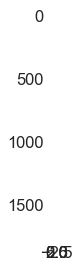

In [125]:
# print(np.sum(np.argmax(clf_A.predict_proba(X_A_train),axis=1) - yC_new),'\n')
plt.imshow(clf_A.predict_proba(X_A_train), cmap='copper', interpolation='nearest')


In [ ]:
yC_new = y_C_train.astype('float')
yC_new

In [55]:
# do we need this stuff (?):

# dump(clf_C, 'cardinality_clf.joblib') 
# dump(clf_A, 'animal_clf.joblib') 

# print('Cardinality accuracy on cardinality test data: {}'.format(clf_C.score(X_C_test, y_C_test)))
# print('Animal accuracy on animal test data: {}'.format(clf_A.score(X_A_test, y_A_test)))
# print('Cardinality accuracy on animal test data: {}'.format(clf_C.score(X_A_test, y_A_test)))
# print('Animal accuracy on cardinality test data: {}'.format(clf_A.score(X_C_test, y_C_test)))



# print(dir(clf))

# coefs_C = clf_C.coef_
# coefs_A = clf_A.coef_

# coefs_C_sorted = coefs_C[:,coefs_C[-1].argsort()]
# coefs_A_sorted = coefs_A[:,coefs_A[-1].argsort()]

# for row in coefs_C_sorted:
#     plt.figure(figsize = (4,4)) #figsize = (16,8)
#     plt.plot(np.arange(len(row)),row,'.')


In [69]:
# is taking distance of means the same as mean of distances?
[1,2,3, 4,5,6]
[3,4,5, 6,7,8]

# first dist, then mean
[2,3,4, 5,6,7] # dist
[3, 6] # mean

# first mean, then dist
[3, 6] # mean
[4, 7] # mean
[3.5, 6.5] # dist

[3.5, 6.5]

# Initial version of the classifier-based things

### within game type, train logistic classifier (5-fold) and measure (1) accuracy & (2) confusion (structure of error; e.g. is 5 often confused with 6? Are deer often confused with bear? Do each for each game type)

In [150]:
# Q = shuffle(D)
Q = D

# from all data
X = np.array(Q[feat_cols])
y_C = Q['cardinality'].values
y_A = Q['animal'].values

# doing it specific to condition
X_A = np.array(shape_games[feat_cols])
X_C = np.array(number_games[feat_cols])

y_AA = shape_games['animal'].values
y_CC = number_games['cardinality'].values
y_AC = shape_games['cardinality'].values
y_CA = number_games['animal'].values

# making training and test sets from number games for cardinalities
X_C_train, X_C_test, y_C_train, y_C_test = train_test_split(X_C, y_CC,
#                                                             stratify=y_C,
                                                            test_size=0.1,
                                                            shuffle=True)
# making training and test sets from shape games for animals
X_A_train, X_A_test, y_A_train, y_A_test = train_test_split(X_A, y_AA,
#                                                             stratify=y_A,
                                                            test_size=0.1,
                                                            shuffle=True)
# making training and test sets from number games for animals
X_CA_train, X_CA_test, y_CA_train, y_CA_test = train_test_split(X_C, y_CA,
#                                                             stratify=y_A,
                                                            test_size=0.1,
                                                            shuffle=True)
# making training and test sets from shape games for cardinalities
X_AC_train, X_AC_test, y_AC_train, y_AC_test = train_test_split(X_A, y_AC,
#                                                             stratify=y_A,
                                                            test_size=0.1,
                                                            shuffle=True)


# congruent: from number game features, predict cardinaliites
clf_C = linear_model.LogisticRegression(penalty='l2',
                                      C=1e-3,
                                      random_state=0,
                                      solver='lbfgs',
                                      multi_class='multinomial',
                                      max_iter=1500).fit(X_C_train, y_C_train) 

# congruent: from shape game features, predict animals
clf_A = linear_model.LogisticRegression(penalty='l2',
                                      C=1e-3,
                                      random_state=0,
                                      solver='lbfgs',
                                      multi_class='multinomial',
                                      max_iter=1500).fit(X_A_train, y_A_train) 

# incongruent: from number game features, predict animals
clf_CA = linear_model.LogisticRegression(penalty='l2',
                                      C=1e-3,
                                      random_state=0,
                                      solver='lbfgs',
                                      multi_class='multinomial',
                                      max_iter=1500).fit(X_CA_train, y_CA_train) 

# incongruent: from shape game features, predict cardinalities
clf_AC = linear_model.LogisticRegression(penalty='l2',
                                      C=1e-3,
                                      random_state=0,
                                      solver='lbfgs',
                                      multi_class='multinomial',
                                      max_iter=1500).fit(X_AC_train, y_AC_train) 







### ACCURACY:

In [152]:


reallyRun = 1
if reallyRun:
    start_time = datetime.now() 
    # congruent tests
    scores_AA = cross_validate(clf_A, X_A_test, y_A_test,
                               cv=5, return_train_score=True)
    scores_CC = cross_validate(clf_C, X_C_test, y_C_test,
                               cv=5, return_train_score=True)

    # incongruent tests
    scores_AC = cross_validate(clf_AC, X_AC_test, y_AC_test,
                               cv=5, return_train_score=True)
    scores_CA = cross_validate(clf_CA, X_CA_test, y_CA_test,
                               cv=5, return_train_score=True)
    
    end_time = datetime.now()
    total_time = end_time - start_time
    print("Congruent:")
    print('Scores (learn animal, test on animal): {}'.format(scores_AA['test_score'])) # learn animal, test on animal
    print('Scores (learn number, test on number): {}'.format(scores_CC['test_score'])) # learn cardinality, test on cardinality
    print("Incongruent:")
    print('Scores (learn animal, test on number): {}'.format(scores_AC['test_score'])) # learn animal, test on cardinality
    print('Scores (learn number, test on animal): {}'.format(scores_CA['test_score'])) # learn cardinality, test on animal
    print('total time: {}'.format(total_time))


Congruent:
Scores (learn animal, test on animal): [0.61904762 0.65       0.83333333 0.58823529 0.58823529]
Scores (learn number, test on number): [0.31818182 0.27272727 0.23809524 0.15       0.13333333]
Incongruent:
Scores (learn animal, test on number): [0.         0.10526316 0.         0.11764706 0.0625    ]
Scores (learn number, test on animal): [0.36363636 0.33333333 0.55       0.36842105 0.33333333]
total time: 0:00:03.516946


0.08036710970883991


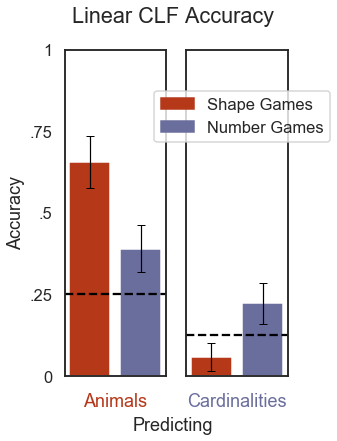

In [153]:

def cf95(arr, z=1.96):
    mean = np.mean(arr)
    std = np.std(arr)
    answer = z * std / np.sqrt(np.size(arr))
    return answer

fig , (ax1,ax2) = plt.subplots(1,2 , sharey=True, figsize = (4,6))

ax1.set_ylim(0,1)

fig.suptitle("Linear CLF Accuracy")


ax1.bar(["AA","CA"],
        [np.mean(scores_AA['test_score']),
         np.mean(scores_CA['test_score'])],
       color = ['#b53819','#6a6e9c'],
       yerr = [cf95(scores_AA['test_score']),
               cf95(scores_CA['test_score'])], error_kw={'linewidth':1.2,'capsize':4})

ax1.set_xlabel("Animals",color='#b53819')
ax1.set_xticklabels([])
ax1.set_yticks([0,.25,.5,.75,1])
ax1.set_yticklabels(['0','.25','.5','.75','1'])

ax2.bar(["AC","CC"],
        [np.mean(scores_AC['test_score']),
         np.mean(scores_CC['test_score'])],
       color = ['#b53819','#6a6e9c'],
       yerr = [cf95(scores_AC['test_score']),
               cf95(scores_CC['test_score'])], error_kw={'linewidth':1.2,'capsize':4})

ax2.set_xlabel("Cardinalities",color='#6a6e9c')
ax2.set_xticklabels([])

l1=ax1.axhline(0.25,color='black',ls='--')
l1.set_label('l1')

l2=ax2.axhline(0.125,color='black',ls='--')
l2.set_label('l2')

ax1.set_ylabel("Accuracy")
fig.text(0.5, 0, 'Predicting', ha='center')

colors = ['#b53819', '#6a6e9c']
texts = ["Shape Games", "Number Games"]
patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
ax2.legend(handles=patches, bbox_to_anchor=(1.5, .9), ncol=1 )



fig.savefig('../results/CLF_acc_layer6.pdf')

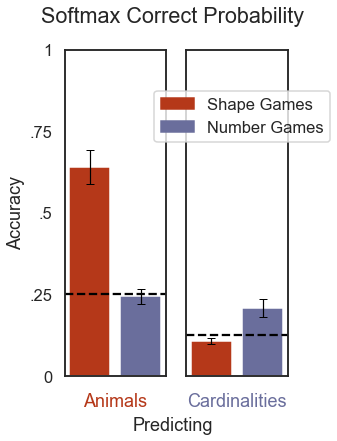

In [155]:
soft_A_all = clf_A.predict_proba(X_A_test)
soft_CA_all = clf_CA.predict_proba(X_CA_test)

soft_C_all = clf_C.predict_proba(X_C_test)
soft_AC_all = clf_AC.predict_proba(X_AC_test)

aml_labels = ['bear','deer','owl','rabbit']
num_labels = ['0','1','2','3','4','5','6','7']

def get_guess(names,softmax,labels):
    guesses = []
    for i in range(len(labels)):
        name = labels[i]
        index = names.index(name)
        guess = softmax[i,index]
        guesses = np.append(guesses,guess)
    return np.array(guesses)

soft_A = get_guess(aml_labels,soft_A_all,y_A_test)
soft_CA = get_guess(aml_labels,soft_CA_all,y_CA_test)

soft_C = get_guess(num_labels,soft_C_all,y_C_test)
soft_AC = get_guess(num_labels,soft_AC_all,y_AC_test)

# copied directly from accuracy bar graph above
fig , (ax1,ax2) = plt.subplots(1,2 , sharey=True, figsize = (4,6))
ax1.set_ylim(0,1)
fig.suptitle("Softmax Correct Probability")
ax1.bar(["A","CA"],
        [np.mean(soft_A),
         np.mean(soft_CA)],
       color = ['#b53819','#6a6e9c'],
       yerr = [cf95(soft_A),
               cf95(soft_CA)], error_kw={'linewidth':1.2,'capsize':4})
ax1.set_xlabel("Animals",color='#b53819')
ax1.set_xticklabels([])
ax1.set_yticks([0,.25,.5,.75,1])
ax1.set_yticklabels(['0','.25','.5','.75','1'])
ax2.bar(["AC","C"],
        [np.mean(soft_AC),
         np.mean(soft_C)],
       color = ['#b53819','#6a6e9c'],
       yerr = [cf95(soft_AC),
               cf95(soft_C)], error_kw={'linewidth':1.2,'capsize':4})
ax2.set_xlabel("Cardinalities",color='#6a6e9c')
ax2.set_xticklabels([])
l1=ax1.axhline(0.25,color='black',ls='--')
l1.set_label('l1')
l2=ax2.axhline(0.125,color='black',ls='--')
l2.set_label('l2')
ax1.set_ylabel("Accuracy")
fig.text(0.5, 0, 'Predicting', ha='center')
colors = ['#b53819', '#6a6e9c']
texts = ["Shape Games", "Number Games"]
patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
ax2.legend(handles=patches, bbox_to_anchor=(1.5, .9), ncol=1 )
fig.savefig('../results/softmax_prob_layer6.pdf')